![CTA first data challenge logo](images/cta-1dc.png)

# CTA data analysis with Gammapy

## Introduction

**This notebook shows an example how to make a sky image and spectrum for simulated CTA data with Gammapy.**

The dataset we will use is three observation runs on the Galactic center. This is a tiny (and thus quick to process and play with and learn) subset of the simulated CTA dataset that was produced for the first data challenge in August 2017.

**This notebook can be considered part 2 of the introduction to CTA 1DC analysis. Part one is here: [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb)**

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!gammapy info --no-envvar --no-system


Gammapy package:

	path                   : /Users/deil/work/code/gammapy/gammapy 
	version                : 0.8.dev6624 
	githash                : f914c2dde9255456dc95a91356de6737cdbb476f 


Other packages:

	numpy                  : 1.14.5     
	scipy                  : 1.1.0      
	matplotlib             : 2.2.2      
	cython                 : 0.28.3     
	astropy                : 3.0.3      
	astropy_healpix        : 0.2        
	reproject              : 0.4        
	sherpa                 : 4.10.0     
	pytest                 : 3.6.2      
	sphinx                 : 1.7.5      
	healpy                 : 1.11.0     
	regions                : 0.2        
	iminuit                : 1.2        
	naima                  : not installed 
	photutils              : 0.4        
	skimage                : 0.14.0     
	uncertainties          : 3.0.2      



In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from photutils.detection import find_peaks
from gammapy.utils.energy import EnergyBounds
from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)
from gammapy.maps import Map, MapAxis, WcsNDMap, WcsGeom
from gammapy.cube import MapMaker
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.detect import TSMapEstimator

In [4]:
# Configure the logger, so that the spectral analysis
# isn't so chatty about what it's doing.
import logging
logging.basicConfig()
log = logging.getLogger('gammapy.spectrum')
log.setLevel(logging.ERROR)

## Select observations

Like explained in [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb), a Gammapy analysis usually starts by creating a `DataStore` and selecting observations.

This is shown in detail in the other notebook, here we just pick three observations near the galactic center.

In [5]:
# data_store = DataStore.from_dir('$CTADATA/index/gps')
data_store = DataStore.from_dir('$GAMMAPY_EXTRA/datasets/cta-1dc/index/gps/')

In [6]:
# Just as a reminder: this is how to select observations
# from astropy.coordinates import SkyCoord
# table = data_store.obs_table
# pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
# pos_target = SkyCoord(0, 0, frame='galactic', unit='deg')
# offset = pos_target.separation(pos_obs).deg
# mask = (1 < offset) & (offset < 2)
# table = table[mask]
# table.show_in_browser(jsviewer=True)

In [7]:
obs_id = [110380, 111140, 111159]
obs_list = data_store.obs_list(obs_id)

In [8]:
obs_cols = ['OBS_ID', 'GLON_PNT', 'GLAT_PNT', 'LIVETIME']
data_store.obs_table.select_obs_id(obs_id)[obs_cols]

OBS_ID,GLON_PNT,GLAT_PNT,LIVETIME
int64,float64,float64,float64
110380,359.9999912037958,-1.2999959379053694,1764.0
111140,358.4999833830074,1.3000020211954266,1764.0
111159,1.5000056568267741,1.299940468335294,1764.0


## Make sky images

### Define map geometry

Select the target position and define an ON region for the spectral analysis

In [9]:
target_position = SkyCoord(0, 0, unit='deg', frame='galactic')
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

In [10]:
axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit='TeV', name='energy'
)
geom = WcsGeom.create(
    skydir=(0, 0),
    npix=(500, 400),
    binsz=0.02,
    coordsys='GAL',
    axes=[axis]
)
geom

WcsGeom

	npix      : 500 x 400 pix
	coordsys  : GAL
	projection: CAR
	center    : 0.0 deg, 0.0 deg
	width     : 10.0 x 8.0 deg
	ndim      : 3
	axes      : energy

### Compute images

We use the ring background estimation method, and an exclusion mask that excludes the bright source at the Galactic center.

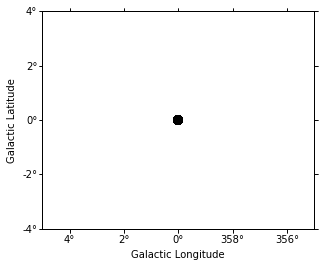

In [11]:
exclusion_mask = geom.to_image().region_mask([on_region], inside=False)
exclusion_mask = WcsNDMap(geom.to_image(), exclusion_mask)
exclusion_mask.plot();

In [12]:
%%time
maker = MapMaker(geom, offset_max='2 deg')
maps = maker.run(obs_list)
print(maps.keys())

dict_keys(['counts', 'exposure', 'background'])
CPU times: user 10.5 s, sys: 733 ms, total: 11.2 s
Wall time: 2.85 s


In [13]:
# The maps are cubes, with an energy axis.
# Let's also make some images:
images = {}
images['counts'] = maps['counts'].sum_over_axes()
images['background'] = maps['background'].sum_over_axes()
images['exposure'] = maps['exposure'].get_image_by_coord({'energy': '1 TeV'})

excess = images['counts'].copy()
excess.data -= images['background'].data
images['excess'] = excess

### Show images

Let's define a little helper function and then show all the resulting images that were computed.

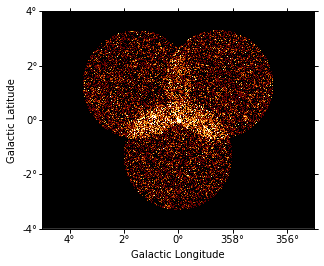

In [14]:
images['counts'].plot(vmax=5);

(<Figure size 432x288 with 1 Axes>,
 None)

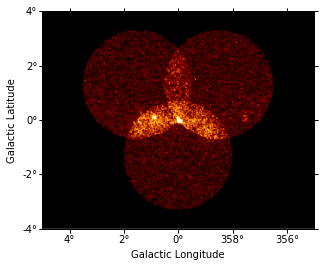

In [15]:
images['counts'].smooth(2).plot(vmax=5)

(<Figure size 432x288 with 1 Axes>,
 None)

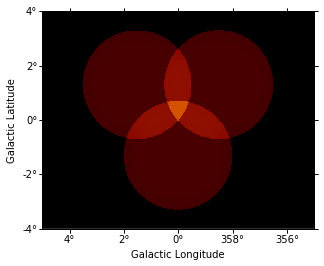

In [16]:
images['background'].plot(vmax=5)

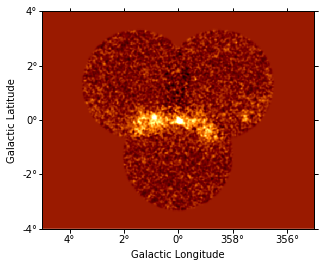

In [17]:
images['excess'].smooth(3).plot(vmax=2);

## Source Detection

Use the class [TSImageEstimator](http://docs.gammapy.org/dev/api/gammapy.detect.compute_ts_image.html#gammapy.detect.TSImageEstimator.html) and [photutils.find_peaks](http://photutils.readthedocs.io/en/stable/api/photutils.find_peaks.html) to detect sources on the images:

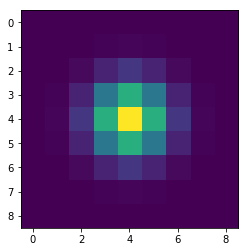

In [18]:
# cut out smaller piece of the PSF image to save computing time
# for covenience we're "misusing" the SkyImage class represent the PSF on the sky.
kernel = Gaussian2DKernel(1, mode='oversample')
plt.imshow(kernel);

In [19]:
%%time
ts_image_estimator = TSMapEstimator()
images_ts = ts_image_estimator.run(images, kernel.array)
print(images_ts.keys())

odict_keys(['ts', 'sqrt_ts', 'flux', 'flux_err', 'flux_ul', 'niter'])
CPU times: user 1.4 s, sys: 170 ms, total: 1.57 s
Wall time: 11.6 s


In [20]:
%%time
sources = find_peaks(
    data=images_ts['sqrt_ts'].data,
    threshold=8,
    wcs=images_ts['sqrt_ts'].geom.wcs,
)
print('Number of sources:', len(sources))

Number of sources: 2
CPU times: user 49.2 ms, sys: 5.11 ms, total: 54.3 ms
Wall time: 26.5 ms


/Users/deil/software/anaconda3/envs/gammapy-dev/lib/python3.6/site-packages/photutils/detection/core.py:241: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))


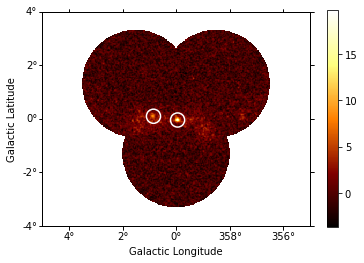

In [21]:
# Plot sources on top of significance sky image
images_ts['sqrt_ts'].plot(add_cbar=True)

plt.gca().scatter(
    sources['icrs_ra_peak'], sources['icrs_dec_peak'],
    transform=plt.gca().get_transform('icrs'),
    color='none', edgecolor='white', marker='o', s=200, lw=1.5,
)

## Spatial analysis

To do a spatial analysis of the data, you can pass the `counts`, `exposure` and `background` image, as well as the `psf` kernel to Sherpa and use Sherpa to fit spatial models.

We plan to add an example to this notebook.

For now, please see [image_fitting_with_sherpa.ipynb](image_fitting_with_sherpa.ipynb) as an extensive tutorial on how to model complex spatial models with Sherpa.

In [22]:
# TODO: fit a Gaussian to the GC source

## Spectrum

We'll run a spectral analysis using the classical reflected regions background estimation method,
and using the on-off (often called WSTAT) likelihood function.

### Extraction

The first step is to "extract" the spectrum, i.e. 1-dimensional counts and exposure and background vectors, as well as an energy dispersion matrix from the data and IRFs.

CPU times: user 15.3 s, sys: 639 ms, total: 16 s
Wall time: 4.72 s


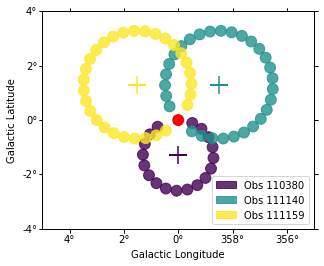

In [23]:
%%time
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    obs_list=obs_list,
    on_region=on_region,
    exclusion_mask=exclusion_mask,
)
bkg_estimator.run()
bkg_estimate = bkg_estimator.result
bkg_estimator.plot();

In [24]:
%%time
extract = SpectrumExtraction(
    obs_list=obs_list,
    bkg_estimate=bkg_estimate,
)
extract.run()
observations = extract.observations

CPU times: user 2.64 s, sys: 110 ms, total: 2.75 s
Wall time: 1.07 s


### Model fit

The next step is to fit a spectral model, using all data (i.e. a "global" fit, using all energies).

In [25]:
%%time
model = models.PowerLaw(
    index = 2,
    amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference = 1 * u.TeV,
)

fit = SpectrumFit(observations, model)
fit.fit()
fit.est_errors()
print(fit.result[0])

/Users/deil/software/anaconda3/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/deil/software/anaconda3/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/deil/software/anaconda3/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/deil/software/anaconda3/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/deil/software/anaconda3/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units

FCN = 0.0 
 TOTAL NCALL = 57 
 NCALLS = 57 
 
 
 EDM = 0.0 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,index,568.889,1.41421,0,0,,,
2,amplitude,-2.38619e-05,1.41421,0,0,,,
3,reference,1,1,0,0,0.0,,FIXED



Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value      error         unit         min    max frozen
	--------- ---------- --------- --------------- --------- --- ------
	    index  5.689e+02       nan                       nan nan  False
	amplitude -2.386e-05       nan 1 / (cm2 s TeV)       nan nan  False
	reference  1.000e+00 0.000e+00             TeV 0.000e+00 nan   True

Covariance: 

	name/name index amplitude
	--------- ----- ---------
	    index   nan       nan
	amplitude   nan       nan 

Statistic: 0.000 (wstat)
Fit Range: [1.e-02 1.e+02] TeV

CPU times: user 2.11 s, sys: 77 ms, total: 2.18 s
Wall time: 559 ms


/Users/deil/software/anaconda3/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/deil/software/anaconda3/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/deil/software/anaconda3/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Spectral points

Finally, let's compute spectral points. The method used is to first choose an energy binning, and then to do a 1-dim likelihood fit / profile to compute the flux and flux error.

In [26]:
# Flux points are computed on stacked observation
stacked_obs = extract.observations.stack()
print(stacked_obs)

ebounds = EnergyBounds.equal_log_spacing(1, 40, 4, unit = u.TeV)

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

fpe = FluxPointEstimator(
    obs=stacked_obs,
    groups=seg.groups,
    model=fit.result[0].model,
)
fpe.compute_points()
fpe.flux_points.table

/Users/deil/work/code/gammapy/gammapy/spectrum/observation.py:849: RuntimeWarning: invalid value encountered in true_divide
  stacked_bkscal_off = self.stacked_off_vector.data.data.value / bkscal_off
/Users/deil/software/anaconda3/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


*** Observation summary report ***
Observation Id: [110380-111159]
Livetime: 1.470 h
On events: 2377
Off events: 34876
Alpha: 0.041
Bkg events in On region: 1435.66
Excess: 941.34
Excess / Background: 0.66
Gamma rate: 0.18 1 / s
Bkg rate: 0.23 1 / min
Sigma: 22.14
energy range: 0.01 TeV - 100.00 TeV


AttributeError: 'SpectrumEnergyGroupMaker' object has no attribute 'compute_range_safe'

### Plot

Let's plot the spectral model and points. You could do it directly, but there is a helper class.
Note that a spectral uncertainty band, a "butterfly" is drawn, but it is very thin, i.e. barely visible.

In [ ]:
total_result = SpectrumResult(
    model=fit.result[0].model,
    points=fpe.flux_points,
)

total_result.plot(
    energy_range = [1, 40] * u.TeV,
    fig_kwargs=dict(figsize=(8,8)),
    point_kwargs=dict(color='green'),
)

## Exercises

* Re-run the analysis above, varying some analysis parameters, e.g.
    * Select a few other observations
    * Change the energy band for the map
    * Change the spectral model for the fit
    * Change the energy binning for the spectral points
* Change the target. Make a sky image and spectrum for your favourite source.
    * If you don't know any, the Crab nebula is the "hello world!" analysis of gamma-ray astronomy.

In [ ]:
# print('hello world')
# SkyCoord.from_name('crab')

## What next?

* This notebook showed an example of a first CTA analysis with Gammapy, using simulated 1DC data.
* This was part 2 for CTA 1DC turorial, the first part was here: [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb)
* More tutorials (not 1DC or CTA specific) with Gammapy are [here](../index.ipynb)
* Let us know if you have any question or issues!